In [1]:
#dependencies
from string import punctuation
from os import listdir
from gensim.models import Word2Vec
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

C:\Users\Arghyadeep\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
def load_data(filename,encoding):
    data = pd.read_csv(filename,encoding=encoding)
    return data

def create_train_test_sets(data,split):
    np.random.seed(0)
    mask = np.random.rand(len(data)) < split
    train_data = data[mask]
    test_data = data[~mask]
    return train_data,test_data

def clean_and_get_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [3]:
data = load_data('bbc/BBC_news.csv','latin1')
words = set()
vocab = {}


token = data['texts'][0].split()
table = str.maketrans('','',punctuation)
tokens = [w.translate(table) for w in token] 
#print(tokens)
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
tokens = [word for word in tokens if len(word)>2]
#print(tokens)

documents = data['texts']
for doc in documents:
    tokens = clean_and_get_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1

for word in vocab:
    if vocab[word] > 2:
        words.add(word)



train_data,test_data = create_train_test_sets(data,0.8)

train_documents = []
for doc in train_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    #final_string = ' '.join(final_tokens)
    train_documents.append(final_tokens)

test_documents = []
for doc in test_data['texts']:
    tokens = doc.split()
    final_tokens = []
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    #final_string = ' '.join(final_tokens)
    test_documents.append(final_tokens)
    

In [4]:
model = Word2Vec(train_documents, size = 100, window = 5, min_count=1)
words = list(model.wv.vocab)
filename = "embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary=False)

In [5]:
def load_embedding(filename):
    #load embedding into memory
    file = open(filename,'r')
    lines = file.readlines()[1:] #skip first line
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

def get_weight_matrix(embedding, word_indices):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(word_indices)+1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in word_indices.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_documents)
encoded_docs = tokenizer.texts_to_sequences(train_documents)

max_length = max(([len(s) for s in train_documents]))
train_labels = train_data['CAT']
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(train_labels, num_classes=5)

encoded_docs = tokenizer.texts_to_sequences(test_documents)
test_labels = test_data['CAT']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(test_labels, num_classes=5)

#print(max_length)

In [7]:
vocab_size = len(tokenizer.word_index)+1
raw_embedding = load_embedding('embedding_word2vec.txt')

weight_matrix = zeros((vocab_size, 100))
for word,i in tokenizer.word_index.items():
    if word in raw_embedding:
        weight_matrix[i] = raw_embedding[word]
#print(weight_matrix)
embedding_layer = Embedding(vocab_size, 100, weights=[weight_matrix], input_length=max_length, trainable=True)

In [8]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1685, 100)         1322900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1678, 32)          25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 839, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26848)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 134245    
Total params: 1,482,777
Trainable params: 1,482,777
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=15, verbose=2, validation_data = (Xtest,ytest))

Train on 1753 samples, validate on 472 samples
Epoch 1/15
 - 7s - loss: 1.5112 - acc: 0.3292 - val_loss: 1.4439 - val_acc: 0.3517
Epoch 2/15
 - 4s - loss: 1.2582 - acc: 0.5048 - val_loss: 1.2488 - val_acc: 0.4979
Epoch 3/15
 - 4s - loss: 0.7280 - acc: 0.7416 - val_loss: 0.8092 - val_acc: 0.6822
Epoch 4/15
 - 4s - loss: 0.3032 - acc: 0.9104 - val_loss: 0.5559 - val_acc: 0.7839
Epoch 5/15
 - 4s - loss: 0.0893 - acc: 0.9875 - val_loss: 0.5286 - val_acc: 0.8072
Epoch 6/15
 - 4s - loss: 0.0278 - acc: 0.9989 - val_loss: 0.4060 - val_acc: 0.8750
Epoch 7/15
 - 4s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.4082 - val_acc: 0.8581
Epoch 8/15
 - 4s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.3765 - val_acc: 0.8856
Epoch 9/15
 - 4s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.3672 - val_acc: 0.8898
Epoch 10/15
 - 4s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.3615 - val_acc: 0.8856
Epoch 11/15
 - 4s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3586 - val_acc: 0.8856
Epoch 12/15
 - 4s - loss: 0.0018 - acc

In [10]:
random_text = ["I love business and sports"]
encoded_text = tokenizer.texts_to_sequences(random_text)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[0.19550407, 0.14542279, 0.28563198, 0.01751138, 0.35592976]],
      dtype=float32)

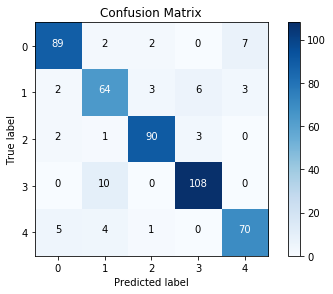

In [12]:
ypred = model.predict(Xtest)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
actual_labels = list(test_labels)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)

import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "Confusion Matrix"
classes = 5
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(5)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()